In [ ]:
import os
import sys
import path
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
sys.path.insert(0, path.Path(os.getcwd()).joinpath("..").abspath())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.display import set_matplotlib_formats

%matplotlib inline
# set_matplotlib_formats("svg")
sns.set_theme(style="whitegrid", font_scale=2, rc={"figure.figsize": (18, 9)})

## Common

In [ ]:
import os

import numpy as np
import pandas as pd
import torch

from captum.attr import visualization as viz
from captum.attr import (
    Saliency, 
    IntegratedGradients,
    NoiseTunnel,
    LayerGradCam, 
    FeatureAblation, 
    LayerActivation, 
    LayerAttribution
)

from matplotlib.colors import LinearSegmentedColormap

----

## TS-based

In [ ]:
from src.settings import DATA_ROOT, LOGS_ROOT
from src.ts import load_ABIDE1, load_OASIS, load_FBIRN

### ABIDE1

In [ ]:
# ABIDE1
features, labels = load_ABIDE1()
features = np.swapaxes(features, 1, 2)  # [n_samples; seq_len; n_features]

In [ ]:
# ABIDE1
# one-sample
feature = features[5].astype(np.float32)
feature = torch.tensor(feature).unsqueeze(0)
feature.requires_grad = True
# all
# feature = features.astype(np.float32)
# feature = torch.tensor(feature)
# feature.requires_grad = True

print(feature.shape)

torch.Size([1, 140, 53])


In [ ]:
# ABIDE1
from src.scripts.tune_ts_mlp import MLP
# AUC: 0.7030812324929973
model = MLP(
    input_size=53, 
    output_size=2,
    hidden_size=75, 
    num_layers=1, 
    dropout=0.30508830411407517,
)
logdir = LOGS_ROOT.joinpath("220428.185640-ts-mlp-qFalse/0002/model.best.pth")
checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# print(checkpoint)
model.load_state_dict(checkpoint)
model = model.eval()
# ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# output = torch.sigmoid(model(feature))

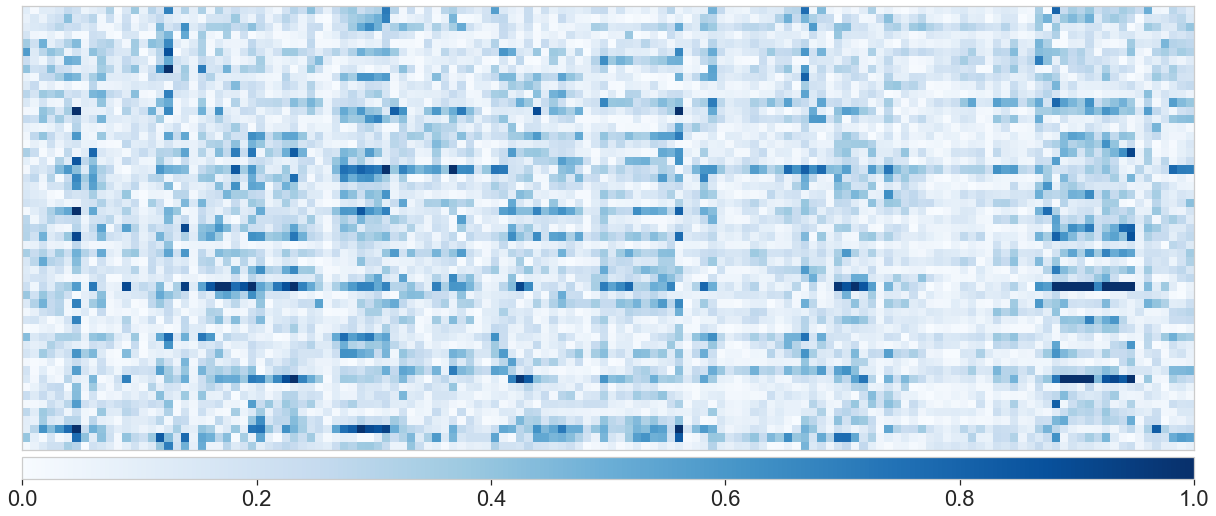

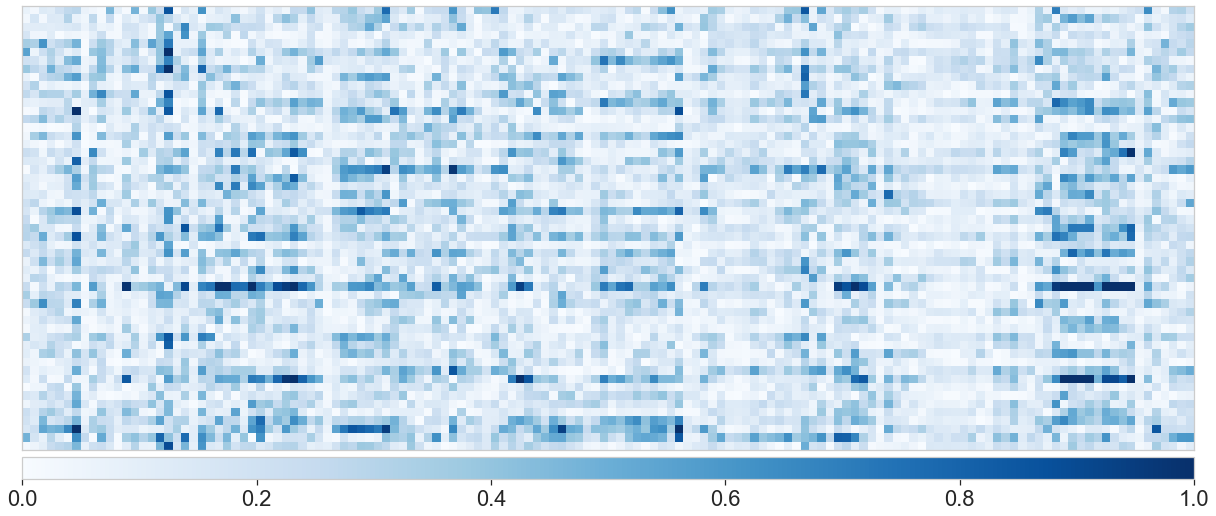

In [ ]:
# ABIDE1
saliency = Saliency(model)

model.zero_grad()
grads0 = saliency.attribute(feature, target=0)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='negative',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
grads1 = saliency.attribute(feature, target=1)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

Approximation delta:  tensor([0.2476], dtype=torch.float64)


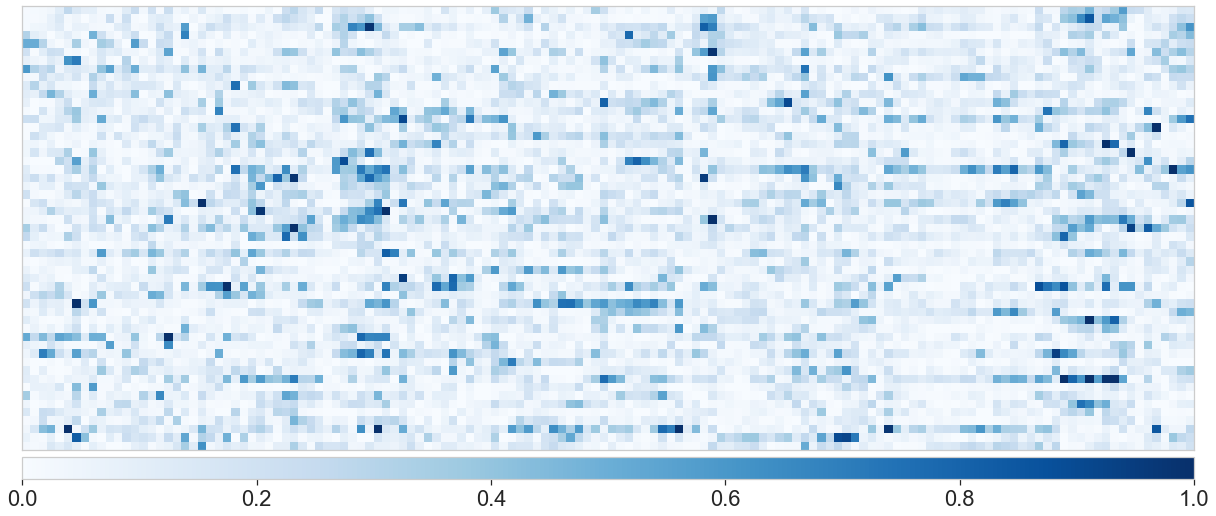

Approximation delta:  tensor([0.5104], dtype=torch.float64)


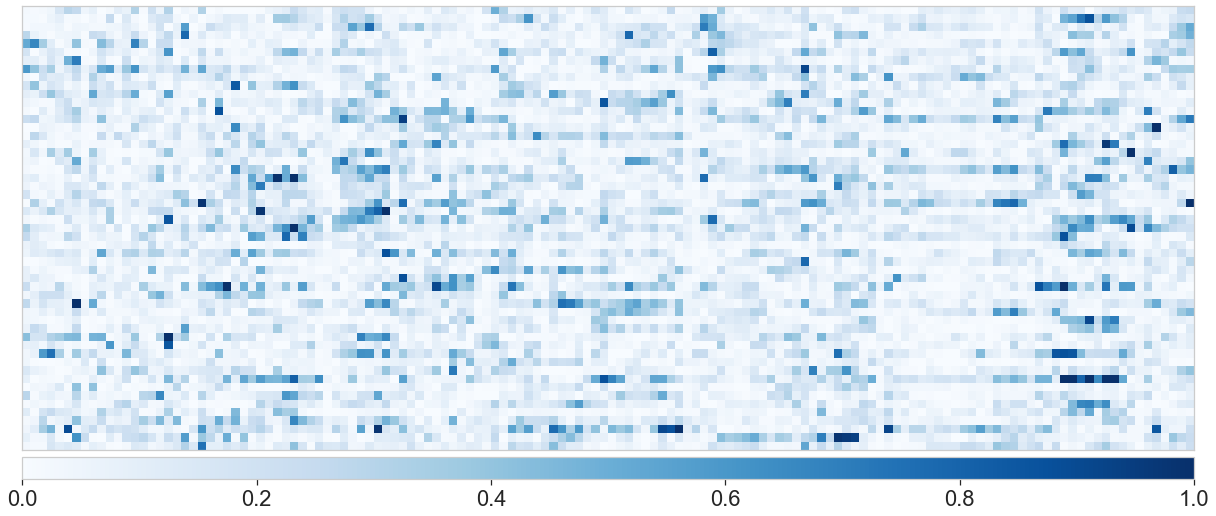

In [ ]:
# ABIDE1
ig = IntegratedGradients(model)


model.zero_grad()
attr_ig0, delta = ig.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig1, delta = ig.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

Approximation delta:  tensor([0.4711, 0.3821, 0.3828, 0.2029, 0.5113], dtype=torch.float64)


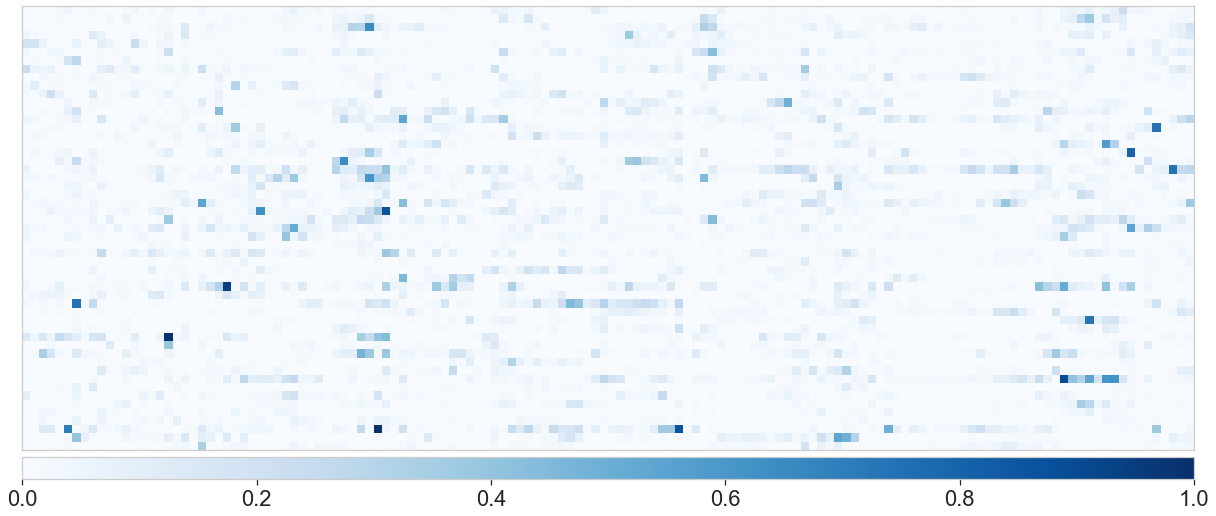

Approximation delta:  tensor([0.7494, 0.5902, 0.5184, 0.5729, 0.5197], dtype=torch.float64)


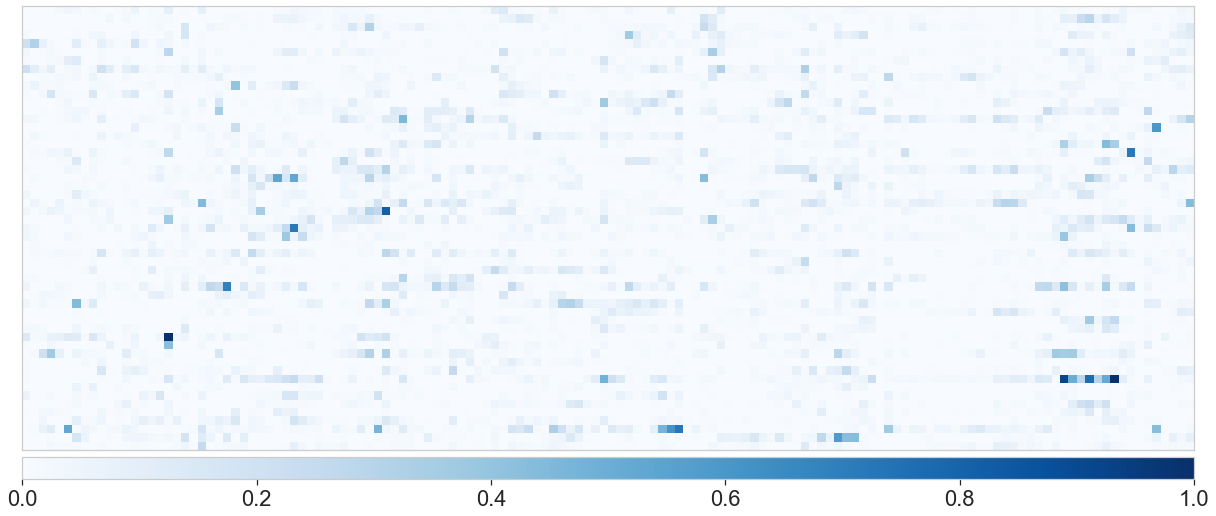

In [ ]:
# ABIDE1
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)


model.zero_grad()
attr_ig_nt0, delta = nt.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig_nt1, delta = nt.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()



### FBIRN

In [ ]:
# FBIRN
features, labels = load_FBIRN()
features = np.swapaxes(features, 1, 2)  # [n_samples; seq_len; n_features]

In [ ]:
# FBIRN
# one-sample
# feature = features[5].astype(np.float32)
# feature = torch.tensor(feature).unsqueeze(0)
# feature.requires_grad = True
# all
feature = features.astype(np.float32)
# print(feature)
feature = torch.tensor(feature)
feature.requires_grad = True

print(feature.shape)

In [ ]:
# FBIRN
from src.scripts.tune_ts_mlp import MLP
# AUC: 0.7376688197298884
model = MLP(
    input_size=53, 
    output_size=2,
    hidden_size=141, 
    num_layers=3, 
    dropout=0.5339434622121335,
)
logdir = LOGS_ROOT.joinpath("220428.220948-ts-mlp-fbirn-qFalse/0004/model.best.pth")
checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
model = model.eval()
# ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# output = torch.sigmoid(model(feature))

In [ ]:
# FBIRN
saliency = Saliency(model)


model.zero_grad()
grads0 = saliency.attribute(feature, target=0)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='negative',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
grads1 = saliency.attribute(feature, target=1)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

In [ ]:
# FBIRN
ig = IntegratedGradients(model)


model.zero_grad()
attr_ig0, delta = ig.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig1, delta = ig.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

In [ ]:
# FBIRN
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)


model.zero_grad()
attr_ig_nt0, delta = nt.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig_nt1, delta = nt.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()



### OASIS

In [ ]:
# OASIS
features, labels = load_OASIS()
features = np.swapaxes(features, 1, 2)  # [n_samples; seq_len; n_features]

In [ ]:
# OASIS
# one-sample
feature = features[5].astype(np.float32)
feature = torch.tensor(feature).unsqueeze(0)
feature.requires_grad = True
# all
# feature = features.astype(np.float32)
# feature = torch.tensor(feature)
# feature.requires_grad = True

# check dimensions
print(feature.shape)

In [ ]:
# OASIS
from src.scripts.tune_ts_mlp_oasis import MLP
# AUC: 0.7702583675866118
model = MLP(
    input_size=53, 
    output_size=2,
    hidden_size=152, 
    num_layers=2, 
    dropout=0.49997745820615697,
)
logdir = LOGS_ROOT.joinpath("220428.205425-ts-mlp-oasis-qFalse/0023/model.best.pth")
checkpoint = torch.load(logdir, map_location=lambda storage, loc: storage)
# print(checkpoint)
model.load_state_dict(checkpoint)

model = model.eval()
# ATTENTION: captum model should have [bs; ...] inputs and [bs; ...] outputs
# output = torch.sigmoid(model(feature))

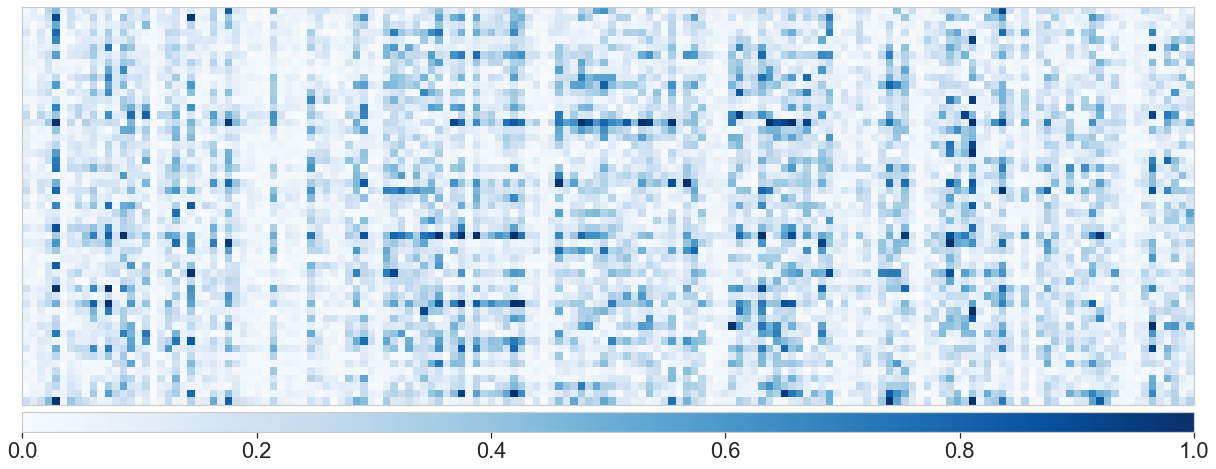

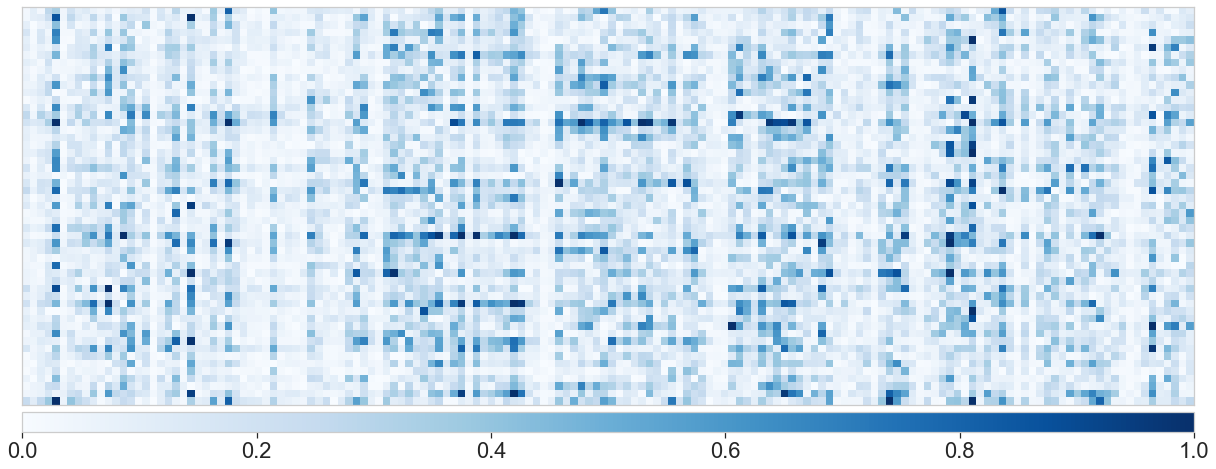

In [ ]:
# OASIS
saliency = Saliency(model)


model.zero_grad()
grads0 = saliency.attribute(feature, target=0)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='negative',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
grads1 = saliency.attribute(feature, target=1)
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

Approximation delta:  tensor([4.1987], dtype=torch.float64)


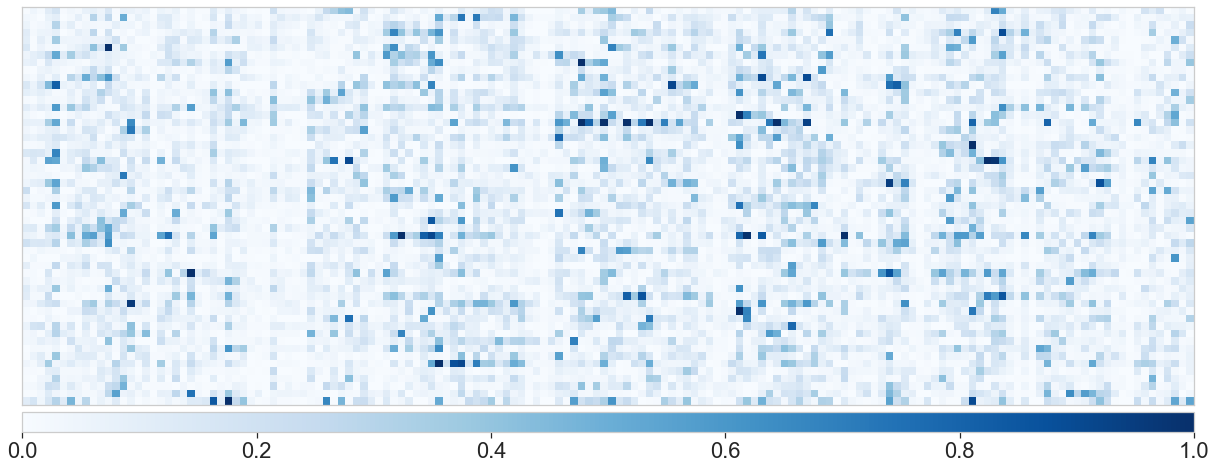

Approximation delta:  tensor([4.9130], dtype=torch.float64)


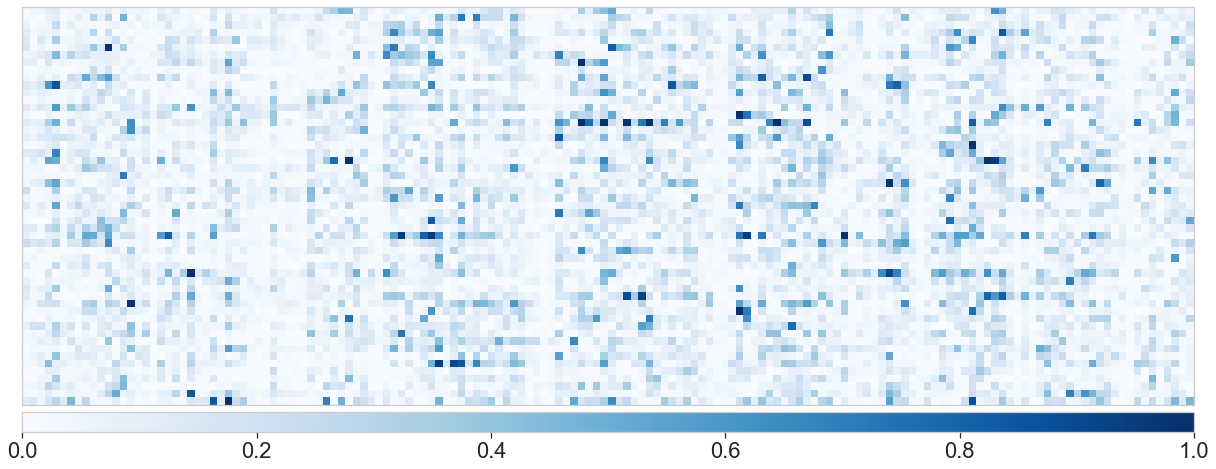

In [ ]:
# OASIS
ig = IntegratedGradients(model)


model.zero_grad()
attr_ig0, delta = ig.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig1, delta = ig.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    # outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

Approximation delta:  tensor([4.0141, 3.5837, 3.7844, 3.5178, 5.1522], dtype=torch.float64)


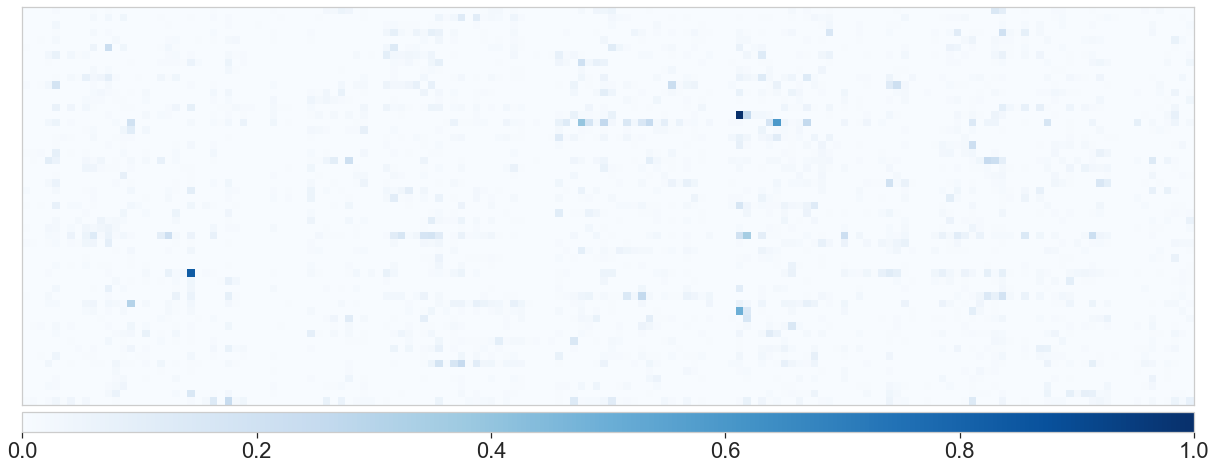

Approximation delta:  tensor([4.1973, 4.1902, 4.9970, 4.9399, 4.3193], dtype=torch.float64)


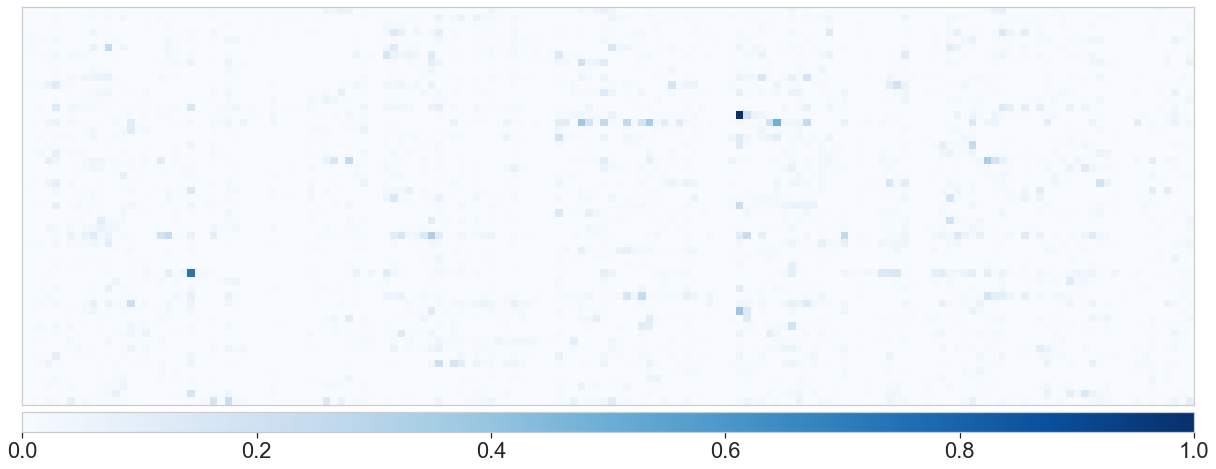

In [ ]:
# OASIS
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)


model.zero_grad()
attr_ig_nt0, delta = nt.attribute(
    inputs=feature,
    target=0,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt0.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()


model.zero_grad()
attr_ig_nt1, delta = nt.attribute(
    inputs=feature,
    target=1,
    baselines=torch.zeros_like(feature),
    return_convergence_delta=True,
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)
print('Approximation delta: ', abs(delta))
fig, axs = plt.subplots(1, 1, figsize=(21, 9))
_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt1.cpu().detach().numpy(), (2,1,0)),
    np.transpose(feature.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    # cmap=default_cmap,
    show_colorbar=True,
    # sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)
plt.show()
plt.close()

